## Imports and utility functions


In [66]:
import numpy as np
import os
import pandas as pd
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import datetime
from os.path import isfile, join
from sys import getsizeof
import glob

from random import *

import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import StratifiedKFold

# from keras import backend as K
import keras as k
from keras import utils, models, layers, optimizers
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from keras.regularizers import l2

import tensorflow as tf



#### Get model eval functionality

In [2]:
%run standard_assessment_metrics_function.ipynb

In [3]:

def NewellCF_calc(v,bz,by):
    # v expected in km/s
    # b's expected in nT    
    NCF = np.zeros_like(v)
    NCF.fill(np.nan)
    bt = np.sqrt(by**2 + bz**2)
    bztemp = bz
    bztemp[bz == 0] = .001
    #Caculate clock angle (theta_c = t_c)
    tc = np.arctan2(by,bztemp)
    neg_tc = bt*np.cos(tc)*bz < 0 
    tc[neg_tc] = tc[neg_tc] + np.pi
    sintc = np.abs(np.sin(tc/2.))
    NCF = (v**1.33333)*(sintc**2.66667)*(bt**0.66667)
    return NCF

def nearest(items, pivot):
    #return min(items, key=lambda x: abs(x - pivot))
    return np.argmin(abs(items - pivot))


def outlier_detect_and_replace(df,str_id,outlier_value):
    """This function takes a dataframe, finds any columns 
    matching 'str_id' in the provided dataframe, and replaces
    all values that exceed the 'outlier_value' with NaN"""
#     print('working on {} outlier detection and removal'.format(str_id))
#     print('outlier value = {}'.format(outlier_value))

    cols = [ col for col in df.columns if str_id in col]
#     print('will detect and replace for columns = {}'.format(cols))
    for i in cols:
        df[i][ df[i] > outlier_value ] = np.NaN

    return df

# Metrics defined by 2019 GNSS FDL team
def dynamic_range_and_mae_loss(y_true, y_pred):
    mae = k.losses.mean_absolute_error(y_true, y_pred)
    dynamic_range_true = k.backend.max(y_true) - k.backend.min(y_true)
    dynamic_range_pred = k.backend.max(y_pred) - k.backend.min(y_pred)
    dynamic_range_loss = dynamic_range_true - dynamic_range_pred
    dynamic_range_loss = k.backend.mean(dynamic_range_loss)
    return mae + 0.1* dynamic_range_loss

def different_exponent(y_true, y_pred):
    # |x-y|^3 with dynamic range
    mae = k.backend.pow(k.backend.abs(y_true-y_pred),3)
    mae = k.backend.mean(mae)
    dynamic_range_true = k.backend.max(y_true) - k.backend.min(y_true)
    dynamic_range_pred = k.backend.max(y_pred) - k.backend.min(y_pred)
    dynamic_range_loss = dynamic_range_true - dynamic_range_pred
    dynamic_range_loss = k.backend.mean(dynamic_range_loss)
    return mae+ 0.1* dynamic_range_loss

def plot_box_summary(df,save_location,save_filename):
    
    '''For plotting box and whisker summary plots for DMSP ML DBs'''
    
    import matplotlib.pyplot as plt
    import os
    import seaborn as sns
    
    # Define styling for each boxplot component
    medianprops = {'color': 'black', 'linewidth': 2}
    boxprops = {'color': 'black', 'linestyle': '-'}
    whiskerprops = {'color': 'red', 'linestyle': '-'}
    capprops = {'color': 'red', 'linestyle': '-'}

    label_units = ['nT','nT','nT']
    label_plots = ['Bz','AE','SymH']

    ctr = 1
    plt.figure()#figsize=(5,2))
    for l in label_plots:
        plt.subplot(310+ctr)
        plt.boxplot(df[l],
                    vert=False,
                    whis=0.75,
                    showfliers=False,
                    boxprops=boxprops,
                    medianprops=medianprops,
                    whiskerprops=whiskerprops,
                    capprops=capprops)
        jitter_val = np.random.normal(1, 0.005, df[l].shape[0])
        plt.scatter(df[l], jitter_val, c='k', alpha=0.4,s=0.05)
        plt.text(np.nanmedian(df[l]),
                 1+.3,
                 'Median' + l + ' = '+str(np.nanmedian(df[l]))+label_units[ctr-1],
                 color='k')
        plt.text(np.nanquantile(df[l],.9),
                 1+.1,
                 '75th' + l + ' = \n    '+str(np.nanquantile(df[l],.75))+label_units[ctr-1],
                 color='r')
        plt.text(np.nanquantile(df[l],.1),
                 1+.1,
                 '25th' + l + ' = \n    '+str(np.nanquantile(df[l],.25))+label_units[ctr-1],
                 color='r')

        plt.xlim([np.min(df[l]),
                  np.max(df[l])])

        plt.ylim([0.8,1.2])
        plt.yticks([1],[l])
        plt.xticks([],[])
        sns.despine(left=True, bottom=True, right=True)

        ctr += 1
        if ctr == 2:
            plt.text(np.nanquantile(df[l],.00001),
             1.2,
             'Number of Observations\n          = '+str(len(df['Bz'])),
             color='b')
    
    # save figure
    plt.savefig(os.path.join(save_location,save_filename))

In [4]:
DMSP_FIGURE_DIR = '/Users/ryanmcgranaghan/Documents/DMSPdata/figures/'
DMSP_DATA_DIR = '/Users/ryanmcgranaghan/Documents/DMSPdata/data/'


## Prepare data for hyperparameter exploration


In [5]:
# Load a sample data set to for column drop definition
files = glob.glob(DMSP_DATA_DIR + 'ML_DB_subsamp_ext_'+str(2010)+'_sat*.csv')
files.sort()

df_cols = pd.read_csv(files[0],index_col=0,nrows=1)
df_cols = df_cols.drop(columns=['key_0'])
df_cols
cols_to_drop_hyperparamsearch = [c for c in df_cols.columns if ('STD' in c) | ('SC_AACGM_LTIME' == c) | ('AVG' in c) ]
cols_to_drop_hyperparamsearch
del df_cols

# Load the cumulative DF saved in standard_ML_DB_preparation.ipynb
import time
start_time = time.time()
df_cumulative = pd.read_csv(os.path.join(DMSP_DATA_DIR,'ML_DB_subsamp_ext_full_dfCumulative_complexHemisphereCombine.csv'),)
df_cumulative = df_cumulative.set_index('Datetimes')
df_cumulative.index = pd.to_datetime(df_cumulative.index)
df_cumulative = df_cumulative.drop(columns=cols_to_drop_hyperparamsearch)
print("--- %s seconds ---" % (time.time() - start_time))



--- 56.77936005592346 seconds ---


In [6]:
# X = df_cumulative[feature_cols].copy(deep=True)
# y = df_cumulative['ELE_TOTAL_ENERGY_FLUX'].copy(deep=True)
# y[y == 0] = 0.0001
# y = np.log10(y)
    
# Save the X and y data for quicker use in hyperparameter search

# Separate training and testing data
mask_val = [(df_cumulative.index.year == 2010) & (df_cumulative['ID_SC'].values==16)]
df_val = df_cumulative[mask_val[0]].copy(deep=True)
df_train = df_cumulative.copy(deep=True).drop( df_cumulative.index[mask_val[0]])
print('validation data shape = {}'.format(df_val.shape))
print('train data shape = {}'.format(df_train.shape))
print('NOTE: we will use CV on the train data below to define model training and testing data,\n  so have called the withheld data *validation* data here')

# Construct X and y
feature_cols = [c for c in df_cumulative.columns if not 'ELE' in c]


X_val = df_val[feature_cols].copy(deep=True)
y_val = df_val['ELE_TOTAL_ENERGY_FLUX'].copy(deep=True)
X_train = df_train[feature_cols].copy(deep=True)
y_train = df_train['ELE_TOTAL_ENERGY_FLUX'].copy(deep=True)
scaler_X = preprocessing.RobustScaler()
scaler_X = scaler_X.fit(X_train.values)
X_val_scaled = scaler_X.transform(X_val.values)
X_train_scaled = scaler_X.transform(X_train.values)

numFeatures = len(X_train.columns.to_list())
feature_labels = X_train.columns.to_list()

        

validation data shape = (55210, 149)
train data shape = (1838283, 149)
NOTE: we will use CV on the train data below to define model training and testing data,
  so have called the withheld data *validation* data here


In [86]:
X_train

,SC_AACGM_LAT,ID_SC,sin_ut,cos_ut,sin_doy,cos_doy,sin_SC_AACGM_LTIME,cos_SC_AACGM_LTIME,F107,Bz,...,AE_5min,AL_5min,AU_5min,SymH_5min,PC_5min,vsw_5min,vx_5min,psw_5min,borovsky_5min,newell_5min
Datetimes,,,,,,,,,,,,,,,,,,,,,
1987-01-12 12:57:00,51.143220,6.0,-0.246153,-0.969231,2.051045e-01,0.978740,0.996134,0.087845,68.9,2.78,...,86.0,-61.0,25.0,3.0,0.77,356.0,-355.5,2.96,17439.640589,2489.686963
1987-01-12 12:58:00,54.137207,6.0,-0.250380,-0.968148,2.051045e-01,0.978740,0.992626,0.121216,68.9,2.78,...,86.0,-61.0,25.0,3.0,0.77,356.0,-355.5,2.96,17439.640589,2489.686963
1987-01-12 13:01:00,62.928176,6.0,-0.263031,-0.964787,2.051045e-01,0.978740,0.968006,0.250928,68.9,1.13,...,82.0,-58.0,24.0,3.0,0.77,354.7,-354.1,3.20,14199.368957,1847.748015
1987-01-12 13:02:00,65.719631,6.0,-0.267238,-0.963630,2.051045e-01,0.978740,0.950633,0.310316,68.9,1.13,...,82.0,-58.0,24.0,3.0,0.77,354.7,-354.1,3.20,14199.368957,1847.748015
1987-01-12 13:03:00,68.392364,6.0,-0.271440,-0.962455,2.051045e-01,0.978740,0.924624,0.380881,68.9,1.13,...,82.0,-58.0,24.0,3.0,0.77,354.7,-354.1,3.20,14199.368957,1847.748015
1987-01-12 13:04:00,70.905061,6.0,-0.275637,-0.961262,2.051045e-01,0.978740,0.885121,0.465360,68.9,1.13,...,82.0,-58.0,24.0,3.0,0.77,354.7,-354.1,3.20,14199.368957,1847.748015
1987-01-28 19:08:00,49.152001,6.0,-0.956305,0.292372,4.635503e-01,0.886071,0.962836,0.270086,70.8,5.87,...,278.0,-233.0,44.0,10.0,0.84,477.1,-475.6,3.75,4846.850759,439.069985
1987-01-28 19:09:00,52.332499,6.0,-0.955020,0.296542,4.635503e-01,0.886071,0.953066,0.302761,70.8,5.87,...,278.0,-233.0,44.0,10.0,0.84,477.1,-475.6,3.75,4846.850759,439.069985
1987-01-28 19:10:00,55.550193,6.0,-0.953717,0.300706,4.635503e-01,0.886071,0.939701,0.341998,70.8,6.76,...,226.0,-180.0,46.0,11.0,0.84,474.6,-472.9,3.75,5327.112485,463.203391


In [23]:
# Deprecated: use 'standard_ML_DB_preparation.ipynb'

# # Save data for later use
# df_cumulative.to_csv(os.path.join(DMSP_DATA_DIR,'ML_DB_subsamp_ext_full_dfCumulative_simpleHemisphereCombine.csv'))
# X_train.to_csv(os.path.join(DMSP_DATA_DIR,'ML_DB_subsamp_ext_full_Xtrain_simpleHemisphereCombine_colsDropped.csv'))
# X_val.to_csv(os.path.join(DMSP_DATA_DIR,'ML_DB_subsamp_ext_full_Xval_simpleHemisphereCombine_colsDropped.csv'))
# y_train.to_csv(os.path.join(DMSP_DATA_DIR,'ML_DB_subsamp_ext_full_ytrain_simpleHemisphereCombine_colsDropped.csv'),
#          header=['ELE_TOTAL_ENERGY_FLUX'])
# y_val.to_csv(os.path.join(DMSP_DATA_DIR,'ML_DB_subsamp_ext_full_yval_simpleHemisphereCombine_colsDropped.csv'),
#          header=['ELE_TOTAL_ENERGY_FLUX'])

## Examine ML model hyperparameters

Four steps
1. Define objective function: a function that takes in hyperparameters and returns a score we are trying to minimize or maximize
2. Define domain of hyperparameters: the set of hyperparameter values over which we want to search.
3. Choose an algorithm: method for selecting the next set of hyperparameters to evaluate in the objective function.
4. Save the results history: data structure containing each set of hyperparameters and the resulting score from the objective function.





### Pre-step: Set constants

In [7]:
random_seed = 7


### Step One: Define objective function
NOTE: accomplished in steps three and four box below

### Step Two: Define domain of hyperparameters


#### Random forests

In [50]:
parameters_rf = {
#               "loss":['deviance'], # only included if Gradient boosting
#               "learning_rate":[0.1], # only included if Gradient boosting
              "n_estimators":[10,100,1000,10000],
              "criterion": ["mse"],
              "min_samples_split": [None,10,100,1000,10000],
              "max_depth": [None, 10, 100],
              "min_samples_leaf": [None, 1, 10, 100],
#                "max_leaf_nodes": [None, 5, 10, 20],
              "max_features":[0.4],
              "random_state":[random_seed],
              }
parameters_grid_rf = ParameterGrid(parameters_rf)
print('number of models to test (rf) = {}'.format(len(parameters_grid_rf)))

number of models to test (rf) = 240


#### Neural Networks

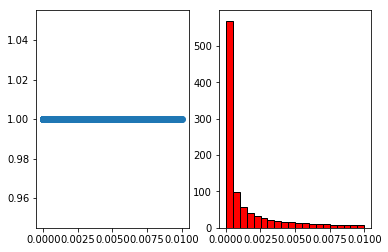

In [28]:
plt.figure()
plt.subplot(121)
plt.plot(np.logspace(-5,-2,1000),np.ones(1000),'o')
plt.subplot(122)
plt.hist(np.logspace(-5,-2,1000), bins = 20, color = 'r', edgecolor = 'k');

In [49]:
parameters_nn = {
              "epochs":list(np.linspace(100,50,10)),#[20,40],#[10,50,100],
              "batch_size":list(np.linspace(100,1000,10)),#[100,1000],#[10,50,100],
              "num_hidden_layers":[1,2,3,4],
#               "num_neurons_by_layer":[ [128],[128,64],[128,64,32],[128,64,32,64]],
              "Dropout":[ 0.5 ],
              "learning_rate":list(np.logspace(-5,-2,10)),
#               "weight_decay":list(np.logspace(-5,-3,10)),
              }
parameters_grid_nn = ParameterGrid(parameters_nn)
print('number of models to test (nn) = {}'.format(len(parameters_grid_nn)))

number of models to test (nn) = 4000


In [67]:
len(parameters_grid_nn)

4000

### Steps Three-Four: Choose algorithm to pick new set of hyperparameter, evaluate each option, and save informative performance


In [87]:
# Create save dataframes

df_cv_loop_columns = ['iteration','MAE','MSE','RMSE','RAE','RSE','RSQ','linear slope','linear intercept']
df_stats_loop_columns = ['Dropout','batch_size','epochs','num_hidden_layers','learning rate',
                                                        'MAE median','MAE mean','MAE variance','MAE std',
                                                        'MSE median','MSE mean','MSE variance','MSE std',
                                                        'RMSE median','RMSE mean','RMSE variance','RMSE std',
                                                        'RAE median','RAE mean','RAE variance','RAE std',
                                                        'RSE median','RSE mean','RSE variance','RSE std',
                                                        'RSQ median','RSQ mean','RSQ variance','RSQ std',
                                                        'linear slope median','linear slope mean','linear slope variance','linear slope std',
                                                        'linear intercept median','linear intercept mean','linear intercept variance','linear intercept std',
                                                       ]
# df_stats_test_loop = pd.DataFrame(columns=df_stats_loop_columns,index=np.arange(len(parameters_grid_nn)))
# df_stats_val_loop = pd.DataFrame(columns=df_stats_loop_columns,index=np.arange(len(parameters_grid_nn)))

num_random_evals = 200
df_stats_test_loop = pd.DataFrame(columns=df_stats_loop_columns,index=np.arange(num_random_evals))
df_stats_val_loop = pd.DataFrame(columns=df_stats_loop_columns,index=np.arange(num_random_evals))
random_params = np.random.choice(len(parameters_grid_nn), num_random_evals)

# Create digitized y for stratified k-fold
from sklearn.model_selection import StratifiedKFold
n_splits = 5
bins = np.linspace(0, 15, 15)
y_train[y_train == 0] = 0.0001
y_val[y_val == 0] = 0.0001
y_train_log = np.log10(y_train.copy(deep=True))
y_val_log = np.log10(y_val.copy(deep=True))

y_train_binned = np.digitize(y_train_log,
                             bins)

p_iteration = 0
# for p in range(len(parameters_grid_nn)): #parameters_grid_nn
for p in range(num_random_evals):
#     print('\n\n\n---------------------\nworking on parameters = {}'.format(parameters_grid_nn[p]))
    
#     epochs = parameters_grid_nn[p]['epochs']
#     batch_size = parameters_grid_nn[p]['batch_size'] 
#     learning_rate = parameters_grid_nn[p]['learning_rate']
#     dropout = parameters_grid_nn[p]['Dropout']
                                 
    print('\n\n\n---------------------\nworking on parameter set number = {}'.format(p))
    print(random_params[p])
    epochs = int(parameters_grid_nn[random_params[p]]['epochs'])
    batch_size = int(parameters_grid_nn[random_params[p]]['batch_size'])
    learning_rate = parameters_grid_nn[random_params[p]]['learning_rate']
    dropout = parameters_grid_nn[random_params[p]]['Dropout']                    
    hidden_layers = parameters_grid_nn[random_params[p]]['num_hidden_layers']
    print('    hl = {}\n    ep = {}\n    ba = {}\n    lr = {}\n    do = {}'.format(hidden_layers,
                                                                                   epochs,
                                                                                   batch_size,
                                                                                   learning_rate,
                                                                                   dropout))
                                 

    # CONSTRUCT THE KERAS MODEL
    model = k.models.Sequential()
    model.add(k.layers.Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'))

    
#     if parameters_grid_nn[p]['num_hidden_layers'] == 1:
#         model.add(k.layers.Dense(64, activation='relu'))
#     if parameters_grid_nn[p]['num_hidden_layers'] == 2:
#         model.add(k.layers.Dense(64, activation='relu'))
#         model.add(k.layers.Dropout(dropout))
#         model.add(k.layers.Dense(32, activation='relu'))
#     if parameters_grid_nn[p]['num_hidden_layers'] == 3:
#         model.add(k.layers.Dense(64, activation='relu'))
#         model.add(k.layers.Dropout(dropout))
#         model.add(k.layers.Dense(32, activation='relu'))    
#         model.add(k.layers.Dense(64, activation='relu'))
#     if parameters_grid_nn[p]['num_hidden_layers'] == 4:
#         model.add(k.layers.Dense(64, activation='relu'))
#         model.add(k.layers.Dense(64, activation='relu'))
#         model.add(k.layers.Dropout(dropout))
#         model.add(k.layers.Dense(32, activation='relu'))    
#         model.add(k.layers.Dense(64, activation='relu'))
                                 
    if hidden_layers == 1:
        model.add(k.layers.Dense(64, activation='relu'))
    if hidden_layers == 2:
        model.add(k.layers.Dense(64, activation='relu'))
        model.add(k.layers.Dropout(dropout))
        model.add(k.layers.Dense(32, activation='relu'))
    if hidden_layers == 3:
        model.add(k.layers.Dense(64, activation='relu'))
        model.add(k.layers.Dropout(dropout))
        model.add(k.layers.Dense(32, activation='relu'))    
        model.add(k.layers.Dense(64, activation='relu'))
    if hidden_layers == 4:
        model.add(k.layers.Dense(64, activation='relu'))
        model.add(k.layers.Dense(64, activation='relu'))
        model.add(k.layers.Dropout(dropout))
        model.add(k.layers.Dense(32, activation='relu'))    
        model.add(k.layers.Dense(64, activation='relu'))  
                                 
    model.add(k.layers.Dense(1, activation='linear'))
    
    # CREATE CROSS-VALIDATION SPLITS
    df_cv_test_loop = pd.DataFrame(columns=df_cv_loop_columns,index=np.arange(n_splits))
    df_cv_val_loop = pd.DataFrame(columns=df_cv_loop_columns,index=np.arange(n_splits))

    iteration = 0
    skf = StratifiedKFold(n_splits=n_splits, random_state=random_seed, shuffle=False)
    for train_index, test_index in skf.split(X_train.values, y_train_binned):
        print('    Working on CV fold = {}'.format(iteration))
        
        # FIT THE MODEL
        model.compile(loss=different_exponent, #dynamic_range_and_mae_loss,
                      optimizer = k.optimizers.Adam(lr=learning_rate),  
                      metrics=['logcosh','mse','mae'])
        history = model.fit(X_train_scaled[train_index],
                            y_train_log[train_index].values, 
                            epochs=epochs, 
                            batch_size=batch_size,
                            validation_data=(X_train_scaled[test_index], y_train_log[test_index].values), 
                            )

        # PREDICT ON THE TEST AND VALIDATION DATA
        y_predict_test = model.predict(X_train_scaled[test_index])
        y_predict_val = model.predict(X_val_scaled)
        
        # CALCULATE METRICS
        MAE_test, MSE_test, RMSE_test, RAE_test, RSE_test, RSQ_test, lin_slope_test, lin_intercept_test = model_eval(y_train_log[test_index].values,y_predict_test)
        MAE_val, MSE_val, RMSE_val, RAE_val, RSE_val, RSQ_val, lin_slope_val, lin_intercept_val = model_eval(y_val_log.values,y_predict_val)
    
        # SAVE METRICS TO DATAFRAMES
        df_cv_test_loop.iloc[iteration,:] = [iteration, MAE_test, MSE_test, RMSE_test, RAE_test, RSE_test, RSQ_test, lin_slope_test, lin_intercept_test]
        df_cv_val_loop.iloc[iteration,:] = [iteration, MAE_val, MSE_val, RMSE_val, RAE_val, RSE_val, RSQ_val, lin_slope_val, lin_intercept_val]

        iteration += 1
    
    # SAVE THE SUMMARY METRICS DATA
#     df_cv_test_loop.to_csv(os.path.join(DMSP_DATA_DIR,'hyperparamsearch_model'+str(p_iteration)+'_cv_results_testData.csv'))
#     df_cv_val_loop.to_csv(os.path.join(DMSP_DATA_DIR,'hyperparamsearch_model'+str(p_iteration)+'_cv_results_validationData.csv'))

    
#     df_stats_test_loop.iloc[p_iteration,:] = np.column_stack([p['Dropout'],p['batch_size'],p['epochs'],p['num_hidden_layers'], 
#                                                            df_cv_test_loop['MAE'].median(), df_cv_test_loop['MAE'].mean(), df_cv_test_loop['MAE'].var(), df_cv_test_loop['MAE'].std(), 
#                                                            df_cv_test_loop['MSE'].median(), df_cv_test_loop['MSE'].mean(), df_cv_test_loop['MSE'].var(), df_cv_test_loop['MSE'].std(), 
#                                                            df_cv_test_loop['RMSE'].median(), df_cv_test_loop['RMSE'].mean(), df_cv_test_loop['RMSE'].var(), df_cv_test_loop['RMSE'].std(), 
#                                                            df_cv_test_loop['RAE'].median(), df_cv_test_loop['RAE'].mean(), df_cv_test_loop['RAE'].var(), df_cv_test_loop['RAE'].std(), 
#                                                            df_cv_test_loop['RSE'].median(), df_cv_test_loop['RSE'].mean(), df_cv_test_loop['RSE'].var(), df_cv_test_loop['RSE'].std(), 
#                                                            df_cv_test_loop['RSQ'].median(), df_cv_test_loop['RSQ'].mean(), df_cv_test_loop['RSQ'].var(), df_cv_test_loop['RSQ'].std(), 
#                                                            df_cv_test_loop['linear slope'].median(), df_cv_test_loop['linear slope'].mean(), df_cv_test_loop['linear slope'].var(), df_cv_test_loop['linear slope'].std(), 
#                                                            df_cv_test_loop['linear intercept'].median(), df_cv_test_loop['linear intercept'].mean(), df_cv_test_loop['linear intercept'].var(), df_cv_test_loop['linear intercept'].std()]) 

    
#     df_stats_val_loop.iloc[p_iteration,:] = np.column_stack([p['Dropout'],p['batch_size'],p['epochs'],p['num_hidden_layers'], 
#                                                            df_cv_val_loop['MAE'].median(), df_cv_val_loop['MAE'].mean(), df_cv_val_loop['MAE'].var(), df_cv_val_loop['MAE'].std(), 
#                                                            df_cv_val_loop['MSE'].median(), df_cv_val_loop['MSE'].mean(), df_cv_val_loop['MSE'].var(), df_cv_val_loop['MSE'].std(), 
#                                                            df_cv_val_loop['RMSE'].median(), df_cv_val_loop['RMSE'].mean(), df_cv_val_loop['RMSE'].var(), df_cv_val_loop['RMSE'].std(), 
#                                                            df_cv_val_loop['RAE'].median(), df_cv_val_loop['RAE'].mean(), df_cv_val_loop['RAE'].var(), df_cv_val_loop['RAE'].std(), 
#                                                            df_cv_val_loop['RSE'].median(), df_cv_val_loop['RSE'].mean(), df_cv_val_loop['RSE'].var(), df_cv_val_loop['RSE'].std(), 
#                                                            df_cv_val_loop['RSQ'].median(), df_cv_val_loop['RSQ'].mean(), df_cv_val_loop['RSQ'].var(), df_cv_val_loop['RSQ'].std(), 
#                                                            df_cv_val_loop['linear slope'].median(), df_cv_val_loop['linear slope'].mean(), df_cv_val_loop['linear slope'].var(), df_cv_val_loop['linear slope'].std(), 
#                                                            df_cv_val_loop['linear intercept'].median(), df_cv_val_loop['linear intercept'].mean(), df_cv_val_loop['linear intercept'].var(), df_cv_val_loop['linear intercept'].std()]) 
    
#     df_stats_test_loop.iloc[p_iteration,:] = np.column_stack([parameters_grid_nn[p]['Dropout'],parameters_grid_nn[p]['batch_size'],parameters_grid_nn[p]['epochs'],parameters_grid_nn[p]['num_hidden_layers'],parameters_grid_nn[p]['learning_rate'], 
#                                                            df_cv_test_loop['MAE'].median(), df_cv_test_loop['MAE'].mean(), df_cv_test_loop['MAE'].var(), df_cv_test_loop['MAE'].std(), 
#                                                            df_cv_test_loop['MSE'].median(), df_cv_test_loop['MSE'].mean(), df_cv_test_loop['MSE'].var(), df_cv_test_loop['MSE'].std(), 
#                                                            df_cv_test_loop['RMSE'].median(), df_cv_test_loop['RMSE'].mean(), df_cv_test_loop['RMSE'].var(), df_cv_test_loop['RMSE'].std(), 
#                                                            df_cv_test_loop['RAE'].median(), df_cv_test_loop['RAE'].mean(), df_cv_test_loop['RAE'].var(), df_cv_test_loop['RAE'].std(), 
#                                                            df_cv_test_loop['RSE'].median(), df_cv_test_loop['RSE'].mean(), df_cv_test_loop['RSE'].var(), df_cv_test_loop['RSE'].std(), 
#                                                            df_cv_test_loop['RSQ'].median(), df_cv_test_loop['RSQ'].mean(), df_cv_test_loop['RSQ'].var(), df_cv_test_loop['RSQ'].std(), 
#                                                            df_cv_test_loop['linear slope'].median(), df_cv_test_loop['linear slope'].mean(), df_cv_test_loop['linear slope'].var(), df_cv_test_loop['linear slope'].std(), 
#                                                            df_cv_test_loop['linear intercept'].median(), df_cv_test_loop['linear intercept'].mean(), df_cv_test_loop['linear intercept'].var(), df_cv_test_loop['linear intercept'].std()]) 

    
#     df_stats_val_loop.iloc[p_iteration,:] = np.column_stack([parameters_grid_nn[p]['Dropout'],parameters_grid_nn[p]['batch_size'],parameters_grid_nn[p]['epochs'],parameters_grid_nn[p]['num_hidden_layers'],parameters_grid_nn[p]['learning_rate'], 
#                                                            df_cv_val_loop['MAE'].median(), df_cv_val_loop['MAE'].mean(), df_cv_val_loop['MAE'].var(), df_cv_val_loop['MAE'].std(), 
#                                                            df_cv_val_loop['MSE'].median(), df_cv_val_loop['MSE'].mean(), df_cv_val_loop['MSE'].var(), df_cv_val_loop['MSE'].std(), 
#                                                            df_cv_val_loop['RMSE'].median(), df_cv_val_loop['RMSE'].mean(), df_cv_val_loop['RMSE'].var(), df_cv_val_loop['RMSE'].std(), 
#                                                            df_cv_val_loop['RAE'].median(), df_cv_val_loop['RAE'].mean(), df_cv_val_loop['RAE'].var(), df_cv_val_loop['RAE'].std(), 
#                                                            df_cv_val_loop['RSE'].median(), df_cv_val_loop['RSE'].mean(), df_cv_val_loop['RSE'].var(), df_cv_val_loop['RSE'].std(), 
#                                                            df_cv_val_loop['RSQ'].median(), df_cv_val_loop['RSQ'].mean(), df_cv_val_loop['RSQ'].var(), df_cv_val_loop['RSQ'].std(), 
#                                                            df_cv_val_loop['linear slope'].median(), df_cv_val_loop['linear slope'].mean(), df_cv_val_loop['linear slope'].var(), df_cv_val_loop['linear slope'].std(), 
#                                                            df_cv_val_loop['linear intercept'].median(), df_cv_val_loop['linear intercept'].mean(), df_cv_val_loop['linear intercept'].var(), df_cv_val_loop['linear intercept'].std()]) 

      
#     df_stats_test_loop.iloc[p_iteration,:] = np.column_stack([parameters_grid_nn[random_params[p]]['Dropout'],parameters_grid_nn[random_params[p]]['batch_size'],parameters_grid_nn[random_params[p]]['epochs'],parameters_grid_nn[random_params[p]]['num_hidden_layers'],parameters_grid_nn[random_params[p]]['learning_rate'], 
    df_stats_test_loop.iloc[p_iteration,:] = np.column_stack([dropout,batch_size,epochs,hidden_layers,learning_rate, 
                                                           df_cv_test_loop['MAE'].median(), df_cv_test_loop['MAE'].mean(), df_cv_test_loop['MAE'].var(), df_cv_test_loop['MAE'].std(), 
                                                           df_cv_test_loop['MSE'].median(), df_cv_test_loop['MSE'].mean(), df_cv_test_loop['MSE'].var(), df_cv_test_loop['MSE'].std(), 
                                                           df_cv_test_loop['RMSE'].median(), df_cv_test_loop['RMSE'].mean(), df_cv_test_loop['RMSE'].var(), df_cv_test_loop['RMSE'].std(), 
                                                           df_cv_test_loop['RAE'].median(), df_cv_test_loop['RAE'].mean(), df_cv_test_loop['RAE'].var(), df_cv_test_loop['RAE'].std(), 
                                                           df_cv_test_loop['RSE'].median(), df_cv_test_loop['RSE'].mean(), df_cv_test_loop['RSE'].var(), df_cv_test_loop['RSE'].std(), 
                                                           df_cv_test_loop['RSQ'].median(), df_cv_test_loop['RSQ'].mean(), df_cv_test_loop['RSQ'].var(), df_cv_test_loop['RSQ'].std(), 
                                                           df_cv_test_loop['linear slope'].median(), df_cv_test_loop['linear slope'].mean(), df_cv_test_loop['linear slope'].var(), df_cv_test_loop['linear slope'].std(), 
                                                           df_cv_test_loop['linear intercept'].median(), df_cv_test_loop['linear intercept'].mean(), df_cv_test_loop['linear intercept'].var(), df_cv_test_loop['linear intercept'].std()]) 

    
#     df_stats_val_loop.iloc[p_iteration,:] = np.column_stack([parameters_grid_nn[random_params[p]]['Dropout'],parameters_grid_nn[random_params[p]]['batch_size'],parameters_grid_nn[random_params[p]]['epochs'],parameters_grid_nn[random_params[p]]['num_hidden_layers'],parameters_grid_nn[random_params[p]]['learning_rate'], 
    df_stats_val_loop.iloc[p_iteration,:] = np.column_stack([dropout,batch_size,epochs,hidden_layers,learning_rate,  
                                                           df_cv_val_loop['MAE'].median(), df_cv_val_loop['MAE'].mean(), df_cv_val_loop['MAE'].var(), df_cv_val_loop['MAE'].std(), 
                                                           df_cv_val_loop['MSE'].median(), df_cv_val_loop['MSE'].mean(), df_cv_val_loop['MSE'].var(), df_cv_val_loop['MSE'].std(), 
                                                           df_cv_val_loop['RMSE'].median(), df_cv_val_loop['RMSE'].mean(), df_cv_val_loop['RMSE'].var(), df_cv_val_loop['RMSE'].std(), 
                                                           df_cv_val_loop['RAE'].median(), df_cv_val_loop['RAE'].mean(), df_cv_val_loop['RAE'].var(), df_cv_val_loop['RAE'].std(), 
                                                           df_cv_val_loop['RSE'].median(), df_cv_val_loop['RSE'].mean(), df_cv_val_loop['RSE'].var(), df_cv_val_loop['RSE'].std(), 
                                                           df_cv_val_loop['RSQ'].median(), df_cv_val_loop['RSQ'].mean(), df_cv_val_loop['RSQ'].var(), df_cv_val_loop['RSQ'].std(), 
                                                           df_cv_val_loop['linear slope'].median(), df_cv_val_loop['linear slope'].mean(), df_cv_val_loop['linear slope'].var(), df_cv_val_loop['linear slope'].std(), 
                                                           df_cv_val_loop['linear intercept'].median(), df_cv_val_loop['linear intercept'].mean(), df_cv_val_loop['linear intercept'].var(), df_cv_val_loop['linear intercept'].std()]) 

      
                                 
    p_iteration += 1
    
# df_stats_test_loop.to_csv(os.path.join(DMSP_DATA_DIR,'hyperparamsearch_Dropout'+str(p['Dropout'])+'_batch'+str(p['batch_size'])+'_epochs'+str(p['epochs'])+'_hiddenlayers'+str(p['num_hidden_layers'])+'_cv_results_testData.csv'))
# df_stats_val_loop.to_csv(os.path.join(DMSP_DATA_DIR,'hyperparamsearch_Dropout'+str(p['Dropout'])+'_batch'+str(p['batch_size'])+'_epochs'+str(p['epochs'])+'_hiddenlayers'+str(p['num_hidden_layers'])+'_cv_results_validationData.csv'))
df_stats_test_loop.to_csv(os.path.join(DMSP_DATA_DIR,'hyperparamsearch_cv_results_testData.csv'))
df_stats_val_loop.to_csv(os.path.join(DMSP_DATA_DIR,'hyperparamsearch_cv_results_validationData.csv'))






---------------------
working on parameter set number = 0
3290
    hl = 3
    ep = 88
    ba = 900
    lr = 4.641588833612782e-05
    do = 0.5
    Working on CV fold = 0
Train on 1470623 samples, validate on 367660 samples
Epoch 1/88
1470623/1470623 [==============================] - 13s 9us/step - loss: 884.6990 - logcosh: 6.0024 - mean_squared_error: 54.4728 - mean_absolute_error: 6.6806 - val_loss: 127.5399 - val_logcosh: 3.0524 - val_mean_squared_error: 18.6756 - val_mean_absolute_error: 3.6951
Epoch 2/88
1470623/1470623 [==============================] - 8s 6us/step - loss: 122.1701 - logcosh: 2.6068 - mean_squared_error: 15.3704 - mean_absolute_error: 3.2321 - val_loss: 50.7727 - val_logcosh: 2.0044 - val_mean_squared_error: 10.0077 - val_mean_absolute_error: 2.6120
Epoch 3/88
1470623/1470623 [==============================] - 6s 4us/step - loss: 62.6462 - logcosh: 1.9037 - mean_squared_error: 9.7448 - mean_absolute_error: 2.5003 - val_loss: 30.2632 - val_logcosh: 1.5051 - val

KeyboardInterrupt: 

#### Examine the previous (prior to AGU) output of NASA laptop hyperparameter search (not the result of the above improved search)

In [42]:
hp_output = pd.read_csv(os.path.join(DMSP_DATA_DIR,'hyperparamsearch_cv_results_validationData.csv'))
hp_output = hp_output.drop(columns=['Unnamed: 0'])
hp_output


,Dropout,batch_size,epochs,num_hidden_layers,MAE median,MAE mean,MAE variance,MAE std,MSE median,MSE mean,...,RSQ variance,RSQ std,linear slope median,linear slope mean,linear slope variance,linear slope std,linear intercept median,linear intercept mean,linear intercept variance,linear intercept std
0,0.5,100,20,1,0.745160,0.861403,0.081534,0.285542,0.912135,1.242932,...,0.125159,0.353778,0.824062,0.801383,0.024056,0.155098,1.385593,1.439240,3.258602,1.805160
1,0.5,100,20,2,0.729282,0.752885,0.002999,0.054760,0.846626,0.912723,...,0.004090,0.063955,0.650096,0.650377,0.002840,0.053294,3.300067,3.165491,0.634380,0.796480
2,0.5,100,20,3,0.711701,0.820844,0.047928,0.218924,0.811174,1.079042,...,0.057745,0.240302,0.666169,0.687919,0.010705,0.103467,3.022552,2.619343,1.970808,1.403855
3,0.5,100,20,4,0.792796,0.810759,0.005189,0.072032,1.004362,0.999956,...,0.004257,0.065247,0.525844,0.509222,0.006435,0.080220,4.236386,4.369185,0.782346,0.884503
4,0.5,100,40,1,0.746598,0.915723,0.184833,0.429922,0.909528,1.438825,...,0.306380,0.553516,0.820111,0.802917,0.002724,0.052192,1.390135,1.311194,0.905333,0.951490
5,0.5,100,40,1,0.744883,0.924146,0.183102,0.427904,0.882619,1.428344,...,0.285549,0.534368,0.814778,0.809256,0.002243,0.047363,1.516359,1.279474,1.063075,1.031055
6,0.5,100,40,2,0.720573,0.897165,0.192231,0.438441,0.795437,1.379033,...,0.324442,0.569598,0.681833,0.663933,0.008108,0.090044,2.572920,2.648353,0.198185,0.445180
7,0.5,100,40,3,0.785230,0.939446,0.128597,0.358605,0.989837,1.452548,...,0.227688,0.477166,0.768644,0.775018,0.004005,0.063287,1.643590,1.803277,0.833699,0.913071
8,0.5,100,40,4,0.733330,0.743410,0.001812,0.042568,0.875173,0.856364,...,0.001084,0.032925,0.586766,0.569810,0.002491,0.049913,3.718409,3.816884,0.336647,0.580213
9,0.5,1000,20,1,0.822911,0.829815,0.005337,0.073054,0.979662,1.019815,...,0.003800,0.061645,0.487565,0.485230,0.004259,0.065258,4.688444,4.685198,0.425143,0.652030


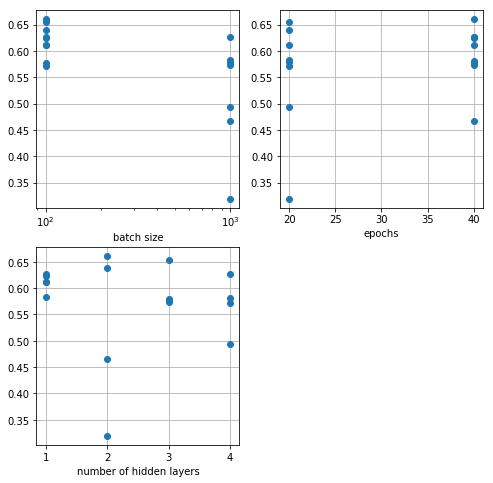

In [60]:
# What are the important hyperparameters
plt.figure(figsize=(8,8))
plt.subplot(221)
plt.plot(hp_output['batch_size'],hp_output['RSQ median'],'o')
plt.xscale('log')
plt.xlabel('batch size')
plt.grid(True)
plt.subplot(222)
plt.plot(hp_output['epochs'],hp_output['RSQ median'],'o')
plt.xlabel('epochs')
plt.grid(True)
plt.subplot(223)
plt.plot(hp_output['num_hidden_layers'],hp_output['RSQ median'],'o')
plt.xlabel('number of hidden layers')
plt.grid(True)



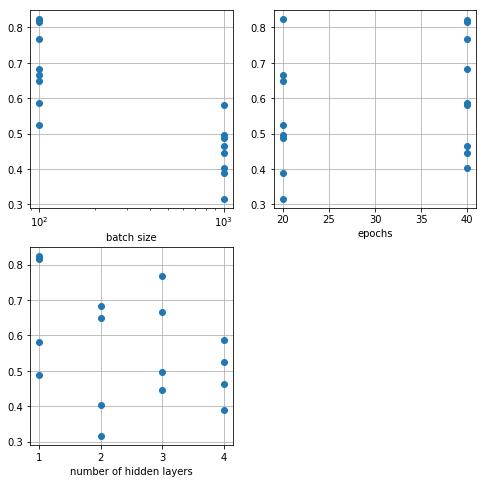

In [61]:
# What are the important hyperparameters
plt.figure(figsize=(8,8))
plt.subplot(221)
plt.plot(hp_output['batch_size'],hp_output['linear slope median'],'o')
plt.xscale('log')
plt.xlabel('batch size')
plt.grid(True)
plt.subplot(222)
plt.plot(hp_output['epochs'],hp_output['linear slope median'],'o')
plt.xlabel('epochs')
plt.grid(True)
plt.subplot(223)
plt.plot(hp_output['num_hidden_layers'],hp_output['linear slope median'],'o')
plt.xlabel('number of hidden layers')
plt.grid(True)



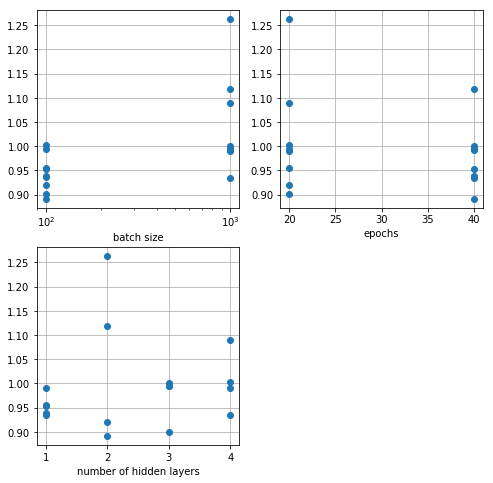

In [62]:
# What are the important hyperparameters
plt.figure(figsize=(8,8))
plt.subplot(221)
plt.plot(hp_output['batch_size'],hp_output['RMSE median'],'o')
plt.xscale('log')
plt.xlabel('batch size')
plt.grid(True)
plt.subplot(222)
plt.plot(hp_output['epochs'],hp_output['RMSE median'],'o')
plt.xlabel('epochs')
plt.grid(True)
plt.subplot(223)
plt.plot(hp_output['num_hidden_layers'],hp_output['RMSE median'],'o')
plt.xlabel('number of hidden layers')
plt.grid(True)



In [ ]:
metrics.make_scorer(different_exponent, greater_is_better=False, needs_proba=False, needs_threshold=False)


In [55]:
(10**1)*(1.60218e-12 * 4* np.pi)

2.013358767091398e-10

## Lessons

- If the hyperparameters are set intelligently at the beginning, then they will perform well throughout the training process (i.e., no episodic variations in the validation loss as a model parameter is varied)

### Making a visual to illustrate hyperparameter search space

<IPython.core.display.Javascript object>


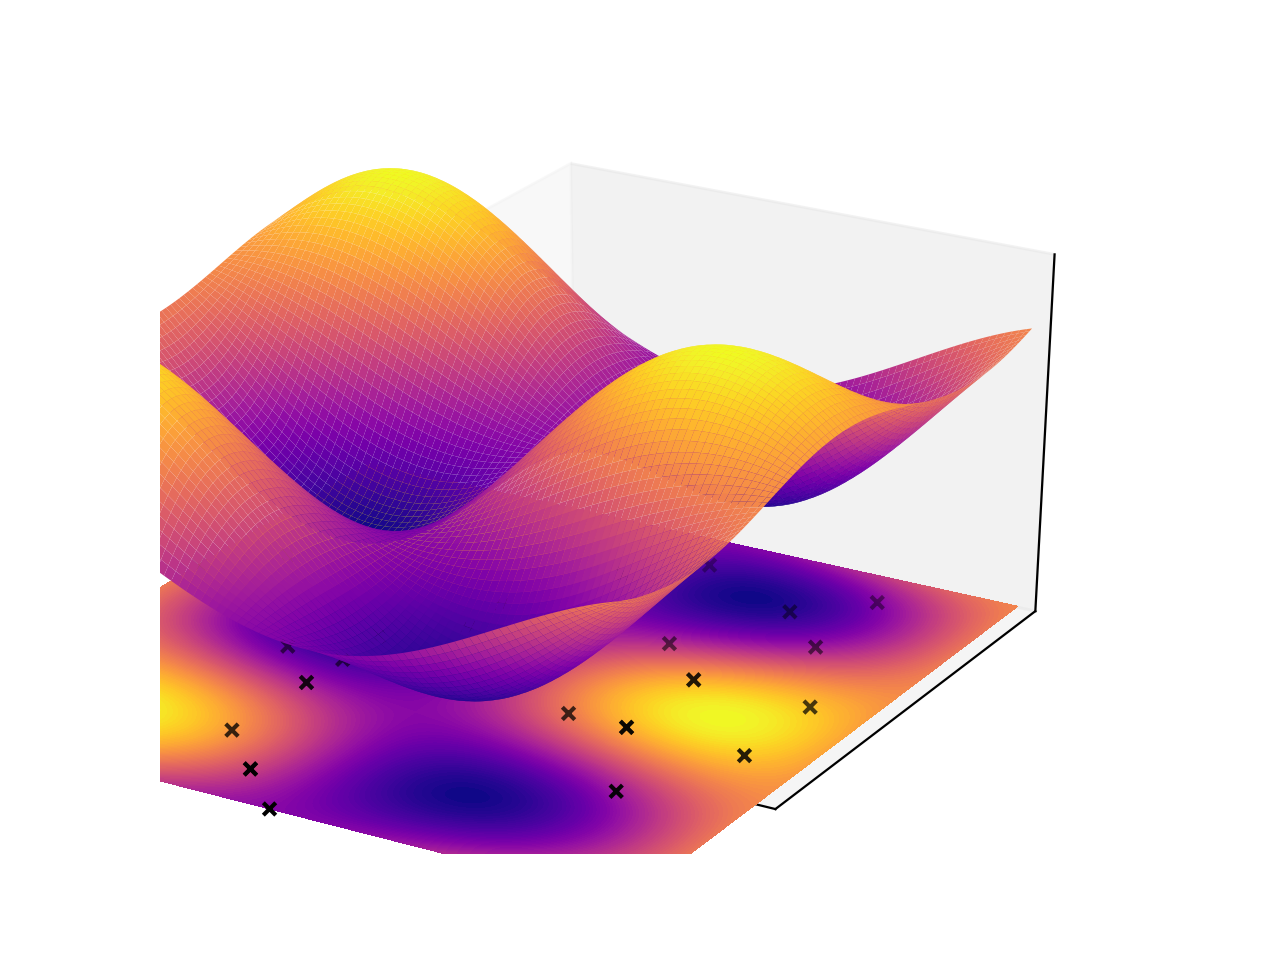

In [139]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d


x= np.arange(-1.5,1.5,0.01)
y= np.arange(-1.5,1.5,0.01)
x_plot= np.arange(-1.5,1.5,0.25)
y_plot= np.arange(-1.5,1.5,0.25)
X_plot,Y_plot = np.meshgrid(x_plot,y_plot)
Z_plot= np.ones_like(X_plot)*-1.5
N = 33
X_plot_random = np.zeros(N)
Y_plot_random = np.zeros(N)
for i in range(N):
    X_plot_random[i] = X_plot[np.random.randint(0, X_plot.shape[0]),np.random.randint(0, X_plot.shape[1])]
    Y_plot_random[i] = Y_plot[np.random.randint(0, X_plot.shape[0]),np.random.randint(0, X_plot.shape[1])]
Z_plot_random= np.ones_like(X_plot_random)*-1.5

z= np.sin(10*x*y)
X,Y = np.meshgrid(x,y)
Z = np.sin(X*2)*np.cos(Y*3) + np.sin(X)*np.sin(X)
fig= plt.figure()
ax= fig.add_subplot(111, projection= '3d')
surf=ax.plot_surface(X,Y,Z,cmap='plasma',linewidth=0,antialiased='True',rstride=3,cstride=3)
ax.contourf(X,Y,Z,100, zdir='z', offset=-1.5,cmap='plasma')
# ax.scatter(X_plot,Y_plot,Z_plot,marker='x',color='k')
ax.scatter(X_plot_random,Y_plot_random,Z_plot_random,marker='x',color='k')
# X_plot[random_indices[:100]]
ax.set_xlim([-0.5, 1.5])
ax.set_ylim([-0.5, 1.5])
ax.set_zlim([-1.5, 1.5])
plt.yticks([])
plt.xticks([])
ax.set_zticks([])
# plt.zticks([])
# ax.set_xlim(xmin, xmax)
# ax.set_ylim(ymin, ymax)
# fig.colorbar(surf)
plt.show()

In [138]:

N = 33
X_plot_random = np.zeros(N)
Y_plot_random = np.zeros(N)
for i in range(N):
    X_plot_random[i] = X_plot[np.random.randint(0, X_plot.shape[0]),np.random.randint(0, X_plot.shape[1])]
    Y_plot_random[i] = Y_plot[np.random.randint(0, X_plot.shape[0]),np.random.randint(0, X_plot.shape[1])]
Z_plot_random= np.ones_like(X_plot_random)*-1.5


In [133]:
X_plot_random

array([ 0.25, -0.5 ,  0.  , -1.5 ,  0.75, -0.75,  0.75, -0.25, -0.25,
        0.25,  0.25, -0.5 ,  0.  , -1.25, -0.75, -0.75, -1.5 ])

In [134]:
Y_plot_random

array([-0.25,  0.75, -0.75,  0.75, -1.  , -1.  ,  0.  ,  0.  , -0.5 ,
        0.25, -1.25, -0.5 , -1.5 , -0.75,  1.25, -0.25, -1.25])